In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

In [4]:
import inspect
lines = inspect.getsource(cluster_quantities_lib.get_e_num_clusters_from_ez)
print(lines)


def get_e_num_clusters_from_ez(e_z):
    """
    EAnalytically computes the expected number of clusters from cluster
    belongings e_z.
    Parameters
    ----------
    e_z : ndarray
        Array whose (n, k)th entry is the probability of the nth
        datapoint belonging to cluster k.
    Returns
    -------
    float
        The expected number of clusters in the dataset.
    """

    k = np.shape(e_z)[1]
    return k - np.sum(np.prod(1 - e_z, axis = 0))



# Load data

In [5]:
# population allele frequencies
true_pop_allele_freq = np.load('../data/true_pop_allele_freq.npy')

# individual admixtures
true_ind_admix_propn = np.load('../data/true_ind_admix_propn.npy')

# observations 
g_obs = np.load('../data/simulated_genotypes.npy')

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_pop = true_pop_allele_freq.shape[1]

print('true_number of populations: ', n_pop)

true_number of populations:  4


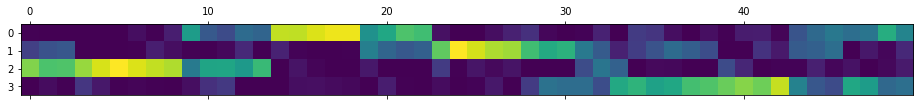

In [6]:
plt.matshow(true_ind_admix_propn.T)

# Load initial fit

In [7]:
init_alpha = 8

# load optimal vb parameters at init_alpha
vb_opt_dict, vb_params_paragami, data =\
    paragami.load_folded('../fits/simulated_data_fit_alpha{}.npz'.format(init_alpha))

# free optimal vb_parameters
vb_opt_free_params = vb_params_paragami.flatten(vb_opt_dict, free = True)

# load prior parameters
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()
prior_params_dict['dp_prior_alpha'] = data['alpha']

# other parameters
gh_deg = int(data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

# assert we are at an optimum 
structure_model_lib.assert_optimizer(g_obs, vb_opt_dict, vb_params_paragami, 
                                     prior_params_dict, gh_loc, gh_weights)

# check results

In [8]:
ind_mix_stick_propn_mean = vb_opt_dict['ind_mix_stick_propn_mean']
ind_mix_stick_propn_info = vb_opt_dict['ind_mix_stick_propn_info']
pop_freq_beta_params = vb_opt_dict['pop_freq_beta_params']

e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        ind_mix_stick_propn_mean, ind_mix_stick_propn_info,
                        gh_loc, gh_weights)

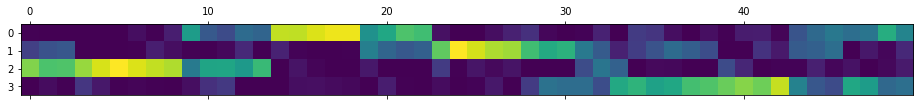

In [9]:
plt.matshow(true_ind_admix_propn.T)

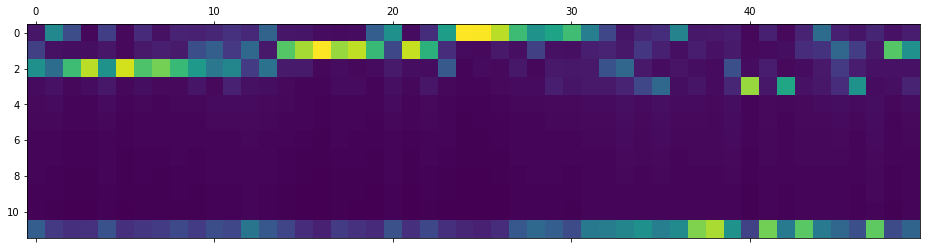

In [10]:
plt.matshow(e_ind_admix.T)

# Parametric sensitivity

## Get linear sensitivity object

In [11]:
get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [12]:
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights),
        opt_par_value = vb_opt_free_params, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
        validate_optimum=False,
        hessian_at_opt=np.load('../fits/hessian_at_alpha{}.npy'.format(init_alpha)),
        # hessian_at_opt=None,
        cross_hess_at_opt=None,
        factorize_hessian=True,
        hyper_par_objective_fun=None,
        grad_tol=1e-8)


# Check for a range of alphas

In [13]:
alpha_vec = np.arange(1, 10)

In [14]:
pert_vb_free_params_array = np.zeros((len(alpha_vec), len(vb_opt_free_params)))
lr_vb_free_params_array = np.zeros((len(alpha_vec), len(vb_opt_free_params)))

for i in range(len(alpha_vec)): 
    # load result 
    vb_pert_opt_dict, _, data =\
        paragami.load_folded('../fits/simulated_data_fit_alpha{}.npz'.format(alpha_vec[i]))

    # free optimal vb_parameters
    pert_vb_free_params = vb_params_paragami.flatten(vb_pert_opt_dict, free = True)

    # load prior parameter
    prior_perturbed_dict = deepcopy(prior_params_dict)
    prior_perturbed_dict['dp_prior_alpha'] = data['alpha']

    # assert we are at an optimum 
    structure_model_lib.assert_optimizer(g_obs, vb_pert_opt_dict, vb_params_paragami, 
                                         prior_perturbed_dict, gh_loc, gh_weights)
    
    # get linear response
    lr_vb_free_params = \
        vb_sens.predict_opt_par_from_hyper_par(
            prior_params_paragami.flatten(prior_perturbed_dict, free = True))
#     lr_vb_free_params = vb_sens.evaluate_taylor_series(prior_params_paragami.flatten(
#                             prior_perturbed_dict, free = True))
    
    pert_vb_free_params_array[i, :] = pert_vb_free_params
    lr_vb_free_params_array[i, :] = lr_vb_free_params
    

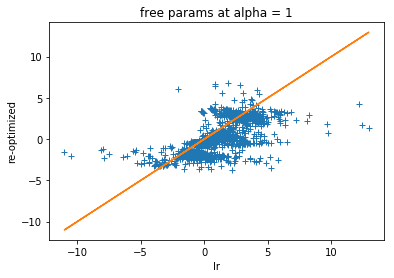

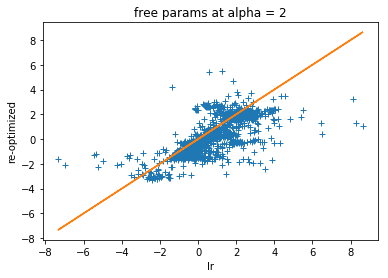

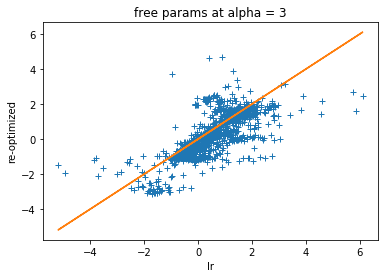

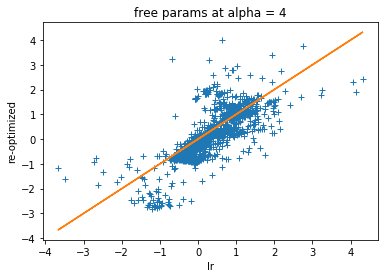

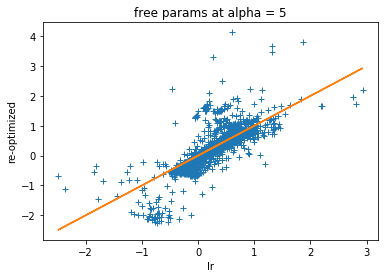

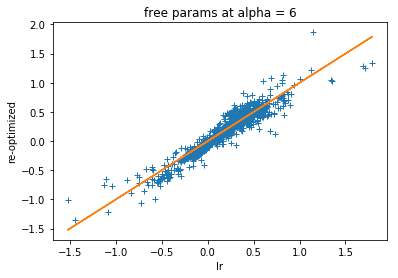

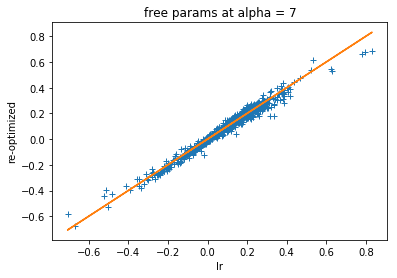

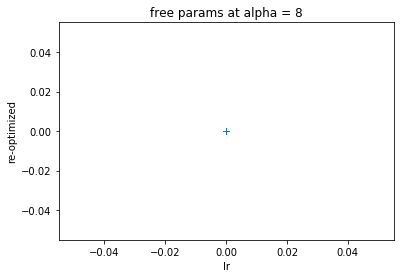

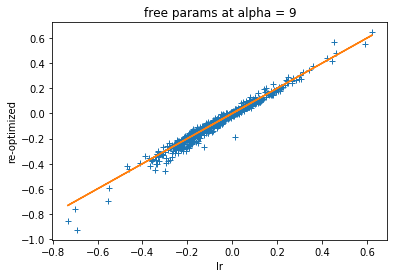

In [15]:
# check results:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_vb_free_params_array[i, :] - vb_opt_free_params, 
            pert_vb_free_params_array[i, :] - vb_opt_free_params, '+')
    plt.plot(lr_vb_free_params_array[i, :] - vb_opt_free_params, 
            lr_vb_free_params_array[i, :] - vb_opt_free_params, '-')
    
    plt.title('free params at alpha = {}'.format(alpha_vec[i]))
    plt.xlabel('lr')
    plt.ylabel('re-optimized')

# check how vb expectations change

In [16]:
def get_vb_expectations(vb_free_params, vb_params_paragami, true_pop_allele_freq): 
    # get vb dict 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free=True)
    
    # get popoulation frequencies
    e_pop_allele_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    # find minimizing permutation 
    if e_pop_allele_freq.shape[1] < 6: 
        perm = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
    else: 
        perm = np.arange(e_pop_allele_freq.shape[1])
    
    # get individual admixutures
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_params_dict['ind_mix_stick_propn_mean'], 
                        vb_params_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)[:, perm]
    
    return e_ind_admix, e_pop_allele_freq[:, perm]

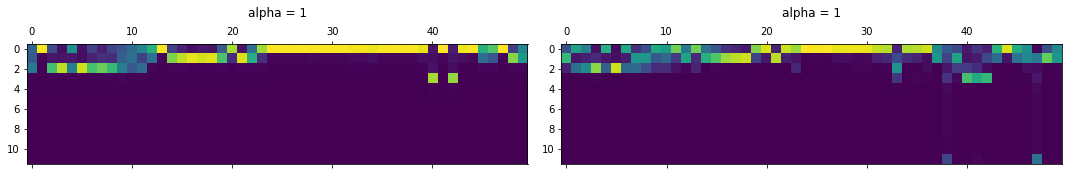

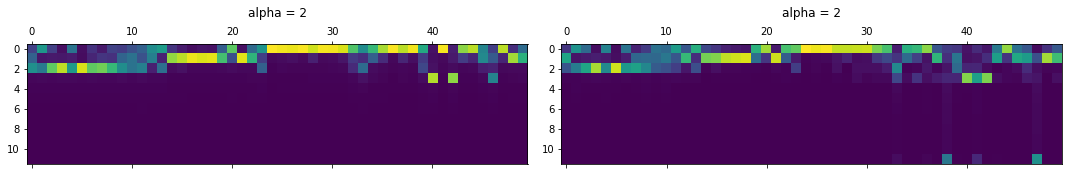

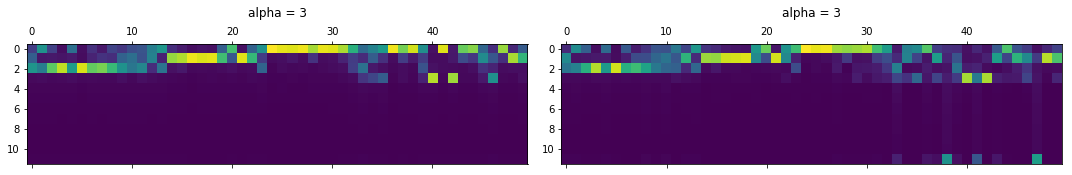

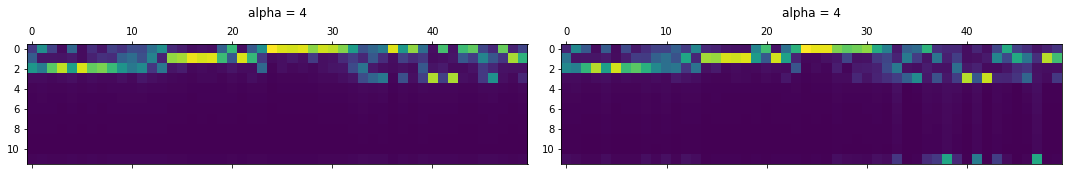

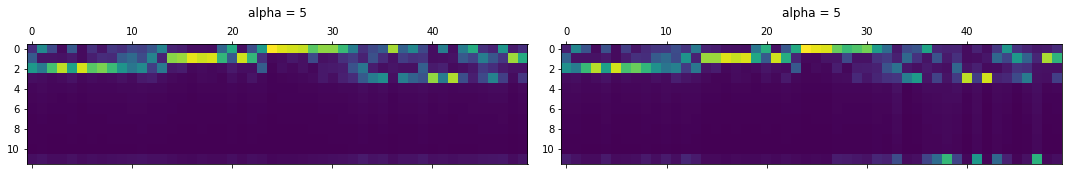

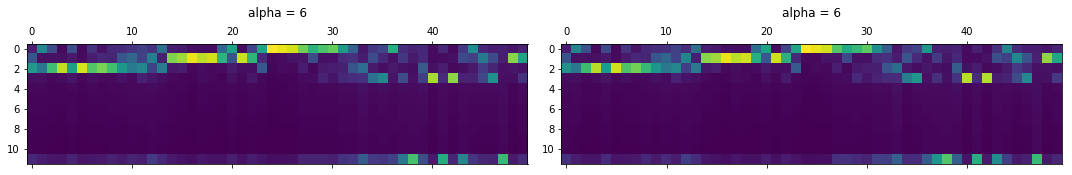

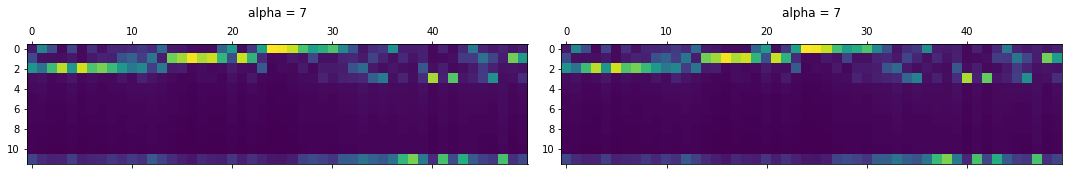

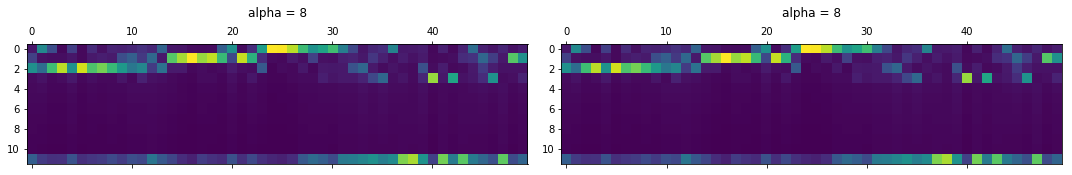

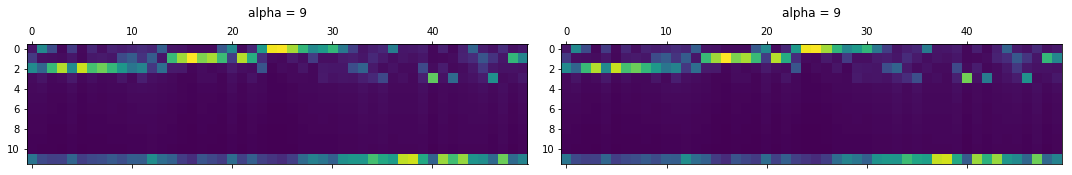

In [17]:
opt_e_ind_admix, opt_e_pop_allele_freq = get_vb_expectations(vb_opt_free_params, 
                                                                vb_params_paragami, 
                                                                true_pop_allele_freq)

pert_e_ind_admix_array = np.zeros((len(alpha_vec), len(opt_e_ind_admix.flatten())))
lr_e_ind_admix_array = np.zeros((len(alpha_vec), len(opt_e_ind_admix.flatten())))

pert_e_pop_allele_freq_array = np.zeros((len(alpha_vec), len(opt_e_pop_allele_freq.flatten())))
lr_e_pop_allele_freq_array = np.zeros((len(alpha_vec), len(opt_e_pop_allele_freq.flatten())))

for i in range(len(alpha_vec)): 
    pert_e_ind_admix, pert_e_pop_allele_freq = \
                    get_vb_expectations(pert_vb_free_params_array[i, :], 
                                                vb_params_paragami, 
                                                true_pop_allele_freq)
    
    lr_e_ind_admix, lr_e_pop_allele_freq = \
                    get_vb_expectations(lr_vb_free_params_array[i, :], 
                                                vb_params_paragami, 
                                                true_pop_allele_freq)
    
    _, axarr = plt.subplots(1, 2, figsize = (15, 15))
    axarr[0].matshow(pert_e_ind_admix.T)
    axarr[1].matshow(lr_e_ind_admix.T)
    axarr[0].set_title('alpha = {}\n'.format(alpha_vec[i]))
    axarr[1].set_title('alpha = {}\n'.format(alpha_vec[i]))
    
    plt.tight_layout()
    
    pert_e_ind_admix_array[i, :] = pert_e_ind_admix.flatten()
    lr_e_ind_admix_array[i, :] = lr_e_ind_admix.flatten()
    
    pert_e_pop_allele_freq_array[i, :] = pert_e_pop_allele_freq.flatten()
    lr_e_pop_allele_freq_array[i, :] = lr_e_pop_allele_freq.flatten()

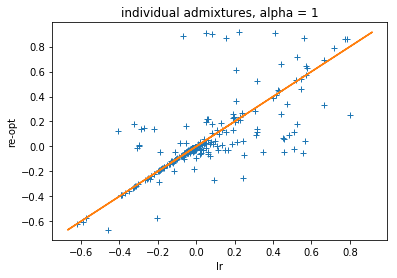

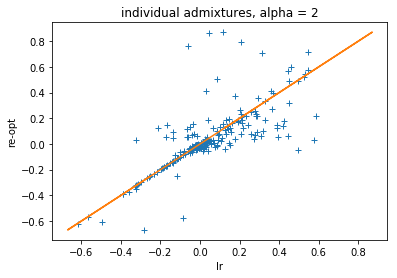

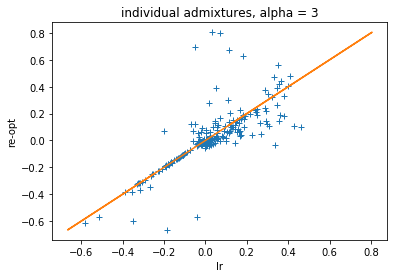

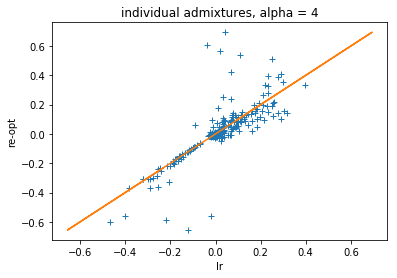

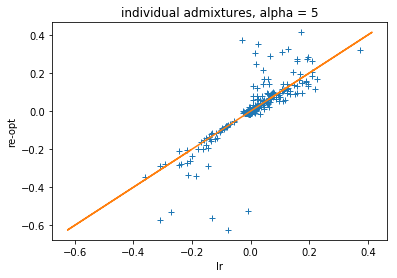

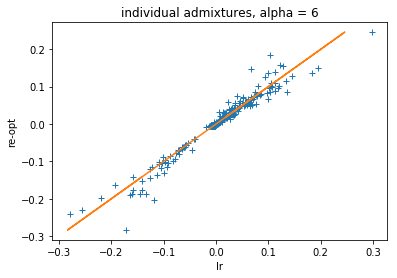

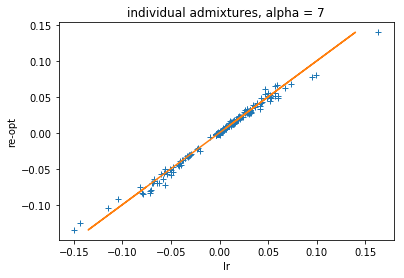

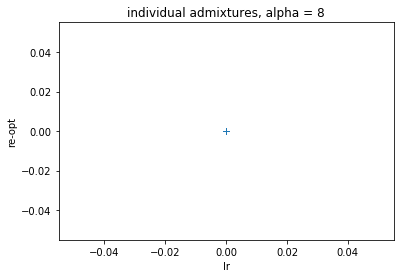

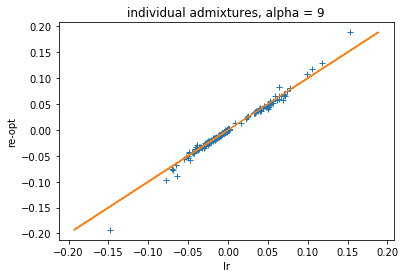

In [18]:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), 
            pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), '+')
    plt.plot(pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), 
            pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), '-')
    plt.title('individual admixtures, alpha = {}'.format(alpha_vec[i]))
    
    plt.xlabel('lr')
    plt.ylabel('re-opt')

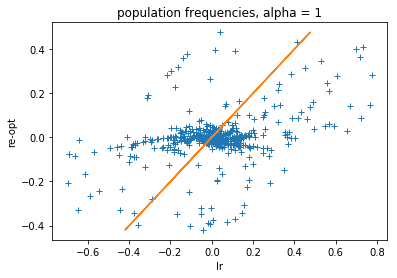

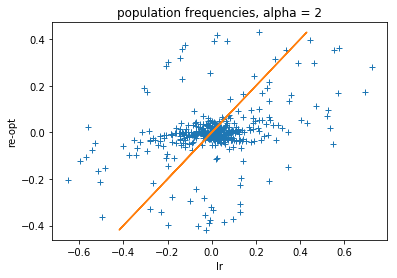

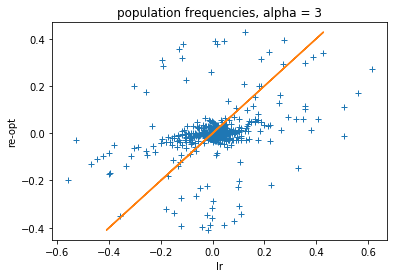

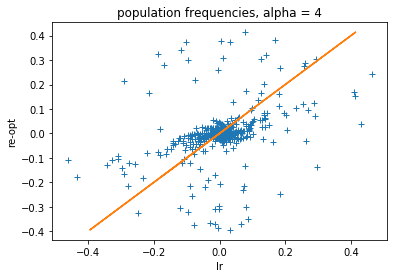

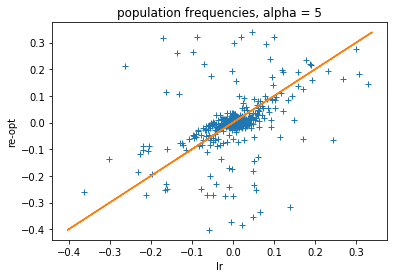

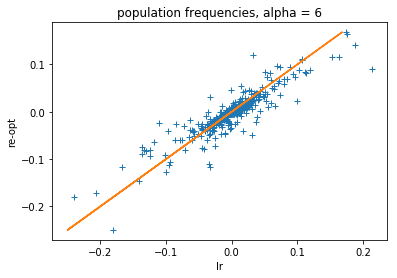

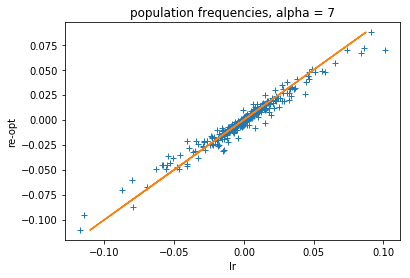

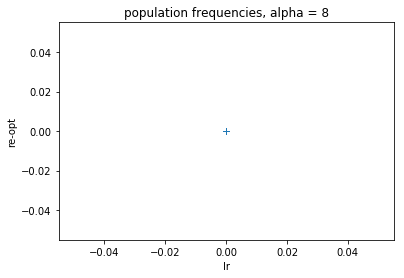

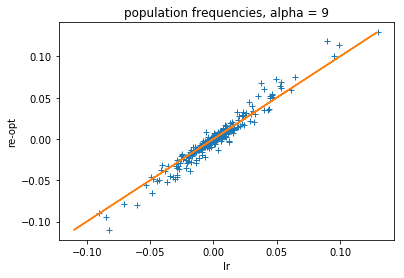

In [19]:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), 
            pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), '+')
    plt.plot(pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), 
            pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), '-')
    plt.title('population frequencies, alpha = {}'.format(alpha_vec[i]))
    plt.xlabel('lr')
    plt.ylabel('re-opt')

# Expected number of clusters

In [20]:
def get_optimal_e_z_from_dicts(vb_params_dict, prior_params_dict, flatten_z = False): 
    # get prior parameters
    dp_prior_alpha = prior_params_dict['dp_prior_alpha']
    allele_prior_alpha = prior_params_dict['allele_prior_alpha']
    allele_prior_beta = prior_params_dict['allele_prior_beta']

    # get vb parameters
    ind_mix_stick_propn_mean = vb_params_dict['ind_mix_stick_propn_mean']
    ind_mix_stick_propn_info = vb_params_dict['ind_mix_stick_propn_info']
    pop_freq_beta_params = vb_params_dict['pop_freq_beta_params']

    e_log_p, e_log_1mp = modeling_lib.get_e_log_beta(pop_freq_beta_params)

    loglik_cond_z = \
                structure_model_lib.get_loglik_cond_z(g_obs, e_log_p, e_log_1mp,
                                ind_mix_stick_propn_mean, ind_mix_stick_propn_info,
                                gh_loc, gh_weights)
    
    e_z = structure_model_lib.get_z_opt_from_loglik_cond_z(loglik_cond_z)
    
    
    if flatten_z: 
        k_approx = e_z.shape[2]
        # e_z is a 4d array of n_obs x n_loci x k_approx x 2
        # we make it a 2d array of (n_obs x n_loci x 2) * k_approx
        e_z_swap = np.swapaxes(e_z, 2, 3)
        e_z_flattened = e_z_swap.reshape(-1, k_approx)
        return e_z_flattened
    else: 
        return e_z

In [22]:
e_num_clusters_lr = np.zeros(len(alpha_vec))
e_num_clusters_pert = np.zeros(len(alpha_vec))

for i in range(len(alpha_vec)):
    
    prior_perturbed_dict = deepcopy(prior_params_dict)
    prior_perturbed_dict['dp_prior_alpha'] = alpha_vec[i]
    z_opt_lr = get_optimal_e_z_from_dicts(vb_params_paragami.fold(lr_vb_free_params_array[i, :], free = True), 
                                       prior_perturbed_dict, flatten_z = True)
    
    z_opt_pert = get_optimal_e_z_from_dicts(vb_params_paragami.fold(pert_vb_free_params_array[i, :], 
                                                                    free = True), 
                                       prior_perturbed_dict, flatten_z = True)
    
    e_num_clusters_lr[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(z_opt_lr)
    e_num_clusters_pert[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(z_opt_pert)
    
    

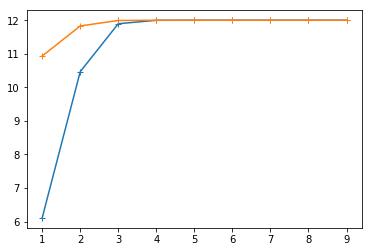

In [23]:
plt.plot(alpha_vec, e_num_clusters_pert, '+-')
plt.plot(alpha_vec, e_num_clusters_lr, '+-')

In [22]:
n_samples = 10000
unif_samples = np.random.random((n_obs * n_loci * 2, n_samples))

threshold = 30

In [28]:
e_num_clusters_lr = np.zeros(len(alpha_vec))
e_num_clusters_pert = np.zeros(len(alpha_vec))

for i in range(len(alpha_vec)):
    
    lr_vb_dict = vb_params_paragami.fold(lr_vb_free_params_array[i, :], free = True)
    pert_vb_dict = vb_params_paragami.fold(pert_vb_free_params_array[i, :], free = True)
    
    e_z_lr = get_optimal_e_z_from_dicts(lr_vb_dict, prior_params_dict, flatten_z=True)
    
    e_z_pert = get_optimal_e_z_from_dicts(pert_vb_dict, prior_params_dict, flatten_z=True)
    
    e_num_clusters_lr[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(e_z_lr,
                                    threshold = threshold,
                                    unif_samples = unif_samples)[0]
    
    e_num_clusters_pert[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(e_z_pert,
                                    threshold = threshold,
                                    unif_samples = unif_samples)[0]
    
    

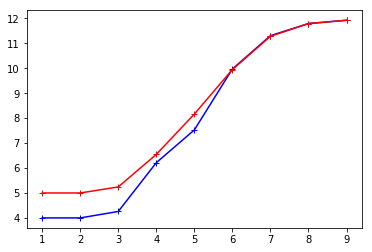

In [29]:
plt.plot(alpha_vec, e_num_clusters_pert, 'b+-')
plt.plot(alpha_vec, e_num_clusters_lr, 'r+-')